In [1]:
import numpy as np

In [2]:
import cloudknot as ck

In [3]:
ck.set_region('us-west-2')

In [4]:
s3_access_pars = ck.Pars(name='s3_access',
                         policies=('AmazonS3FullAccess',),
                         use_default_vpc=False)

In [5]:
import boto3

In [6]:

client = boto3.resource('s3')
bucket_name = 'arokem.mri2mri'
b = client.Bucket(bucket_name)


In [7]:
T1_list = [ll.key for ll in list(b.objects.all())[1:] if (ll.key.startswith("IXI-data/multimodal_registration/") and ll.key.endswith('T1.nii.gz'))]

In [8]:
T1_list[0]

'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI012-HH-1211-T1.nii.gz'

In [9]:
def compare_registrations(t1_path):
    import os.path as op

    import boto3
    import numpy as np
    from AFQ import registration as reg
    import nibabel as nib
    from dipy.core.geometry import decompose_matrix
    
    client = boto3.resource('s3')
    bucket_name = 'arokem.mri2mri'
    b = client.Bucket(bucket_name)

    data_path = op.split(t1_path)[0]
#     if data_path.find("DTI-00") >= 0:
#         source_string = 'DTI-00_transformed.nii.gz'
#     if data_path.find("DTI-08") >= 0:
#         source_string = 'DTI-08_transformed.nii.gz'
#     elif data_path.find("T2") >= 0:
#         source_string = 'T2_transformed.nii.gz'
    
    source_string = 'DTI-00_transformed.nii.gz'
    
    print("Downloading %s as target"%t1_path)
    b.download_file(t1_path, 'target.nii.gz')
    img_target = nib.load('target.nii.gz')
    source_path = op.join(data_path, op.split(t1_path)[1].split('T1')[0] + source_string)
    print("Downloading %s as source"%source_path)
    b.download_file(source_path, 'source.nii.gz')
    img_source = nib.load('source.nii.gz')
    pred_path = op.join(data_path,  op.split(t1_path)[1].split('T1')[0]+ 'T1_transformed_predict.nii.gz')
    print("Downloading %s as prediction"%pred_path)
    b.download_file(pred_path, 'pred.nii.gz')
    img_pred = nib.load('pred.nii.gz')

    data_source = img_source.get_data()
    data_target = img_target.get_data()
    data_pred = img_pred.get_data()
    print("Registering source to target")
    transformed_source, reg_affine_source = reg.affine_registration(moving=data_target, 
                                                                    static=data_source, 
                                                                    moving_affine=img_target.affine,
                                                                    static_affine=img_source.affine,
                                                                    level_iters=[10000, 10000, 10000])
    print("Registering prediction to target")
    transformed_pred, reg_affine_pred = reg.affine_registration(moving=data_target, 
                                                                static=data_pred, 
                                                                moving_affine=img_target.affine,
                                                                static_affine=img_pred.affine,
                                                                level_iters=[10000, 10000, 10000])
    
    print("Calculating registration errors")
    scale_source, shear_source, angles_source, translate_source, perspective_source = decompose_matrix(reg_affine_source)
    scale_pred, shear_pred, angles_pred, translate_pred, perspective_pred = decompose_matrix(reg_affine_pred)

    this_RMS_trans_source = np.mean(np.abs(translate_source))
    this_RMS_trans_pred = np.mean(np.abs(translate_pred))
    this_RMS_rot_source = np.mean(np.abs(angles_source))
    this_RMS_rot_pred = np.mean(np.abs(angles_pred))

    
    results_file = open('results_%s.txt'%op.split(t1_path)[-1], 'w')
    print("Writing results to %s"%results_file)
    results_file.write('%2.8f\t %2.8f\t %2.8f\t %2.8f\t' % (this_RMS_trans_pred, 
                                                            this_RMS_rot_pred,
                                                            this_RMS_trans_source,
                                                            this_RMS_rot_source))
    results_file.close()
    upload_file = op.join(data_path, results_file.name)
    print("Uploading results to %s" % upload_file)
    b.upload_file(results_file.name, upload_file)

In [10]:
#compare_registrations(T1_list[0])

In [11]:
image = ck.DockerImage(func=compare_registrations, github_installs="https://github.com/yeatmanlab/pyAFQ.git")

In [12]:
image.docker_path

'/Users/arokem/projects/mri2mri/cloudknot_docker_compare_registrations_05rjdagn/Dockerfile'

In [14]:
image.build(tags='0.3')

In [15]:
image.images

[{'name': 'cloudknot/compare_registrations', 'tag': '0.3'}]

In [16]:
reg_knot = ck.Knot(name='compare_registrations4',
                   docker_image=image,
                   pars=s3_access_pars, 
                   resource_type="SPOT", 
                   bid_percentage=100)

In [15]:
#reg_knot.clobber()

In [17]:
result = reg_knot.map(T1_list)

In [18]:
j0 = reg_knot.jobs[0]

In [23]:
j0.status

{'status': 'SUCCEEDED',
 'statusReason': None,
 'attempts': [],
 'arrayProperties': {'statusSummary': {'STARTING': 0,
   'FAILED': 0,
   'RUNNING': 0,
   'SUCCEEDED': 395,
   'RUNNABLE': 0,
   'SUBMITTED': 0,
   'PENDING': 0},
  'size': 395}}

In [53]:
foo = ['IXI-data/multimodal_registration/dti00_t1_L1Only/IXI012-HH-1211-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI013-HH-1212-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI025-Guys-0852-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI034-HH-1260-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI046-Guys-0824-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI048-HH-1326-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI049-HH-1358-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI051-HH-1328-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI057-HH-1342-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI059-HH-1284-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI079-HH-1388-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI097-HH-1619-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI131-HH-1527-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI162-HH-1548-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI174-HH-1571-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI176-HH-1604-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI202-HH-1526-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI211-HH-1568-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI221-HH-1606-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI244-Guys-0841-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI246-Guys-0840-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI250-Guys-0836-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI257-HH-1724-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI261-HH-1704-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI265-Guys-0845-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI277-HH-1770-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI278-HH-1771-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI280-HH-1860-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI288-Guys-0879-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI308-Guys-0884-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI329-HH-1908-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI341-Guys-0906-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI356-HH-2049-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI365-Guys-0923-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI369-Guys-0924-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI393-Guys-0941-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI396-HH-2115-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI411-Guys-0959-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI416-Guys-1051-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI418-Guys-0956-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI436-HH-2153-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI441-HH-2154-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI448-HH-2393-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI451-HH-2212-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI458-Guys-0993-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI460-Guys-0999-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI465-HH-2176-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI482-HH-2178-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI488-Guys-1015-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI490-Guys-1018-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI492-Guys-1022-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI493-Guys-1007-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI495-Guys-1009-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI502-Guys-1020-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI515-HH-2377-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI518-HH-2239-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI522-HH-2453-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI527-HH-2376-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI528-Guys-1073-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI539-Guys-1067-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI546-HH-2450-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI551-Guys-1065-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI556-HH-2452-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI559-HH-2394-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI565-HH-2534-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI569-Guys-1101-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI582-Guys-1127-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI592-Guys-1085-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI598-HH-2606-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI613-HH-2734-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI617-Guys-1090-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI623-Guys-1076-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI632-HH-2652-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI633-HH-2689-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI634-HH-2690-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI636-HH-2733-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI642-Guys-1104-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI644-Guys-1121-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI652-Guys-1116-T1.nii.gz']

In [57]:
79 * 5

395

In [55]:
237 / 3

79.0

In [52]:
T1_list

['IXI-data/multimodal_registration/dti00_t1_L1Only/IXI012-HH-1211-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI013-HH-1212-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI025-Guys-0852-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI034-HH-1260-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI046-Guys-0824-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI048-HH-1326-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI049-HH-1358-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI051-HH-1328-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI057-HH-1342-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI059-HH-1284-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI079-HH-1388-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI097-HH-1619-T1.nii.gz',
 'IXI-data/multimodal_registration/dti00_t1_L1Only/IXI131-HH

In [59]:
reg_knot.clobber()

In [22]:
j0 = reg_knot.jobs[0]

In [23]:
j0.region

'us-west-2'

In [26]:
j0.job_queue.profile

'default'

In [26]:
import nibabel as nib

/Users/arokem/.virtualenvs/afq/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [31]:
source = nib.load('source.nii.gz').get_data()
pred = nib.load('pred.nii.gz').get_data()
target = nib.load('target.nii.gz').get_data()

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

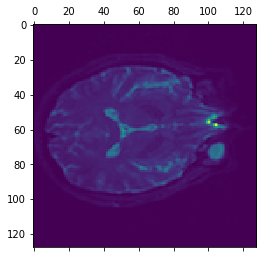

In [44]:
plt.matshow(source[:, :, target.shape[2]//2])

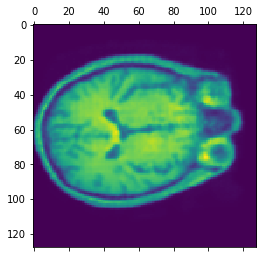

In [45]:
plt.matshow(pred[:, :, target.shape[2]//2])

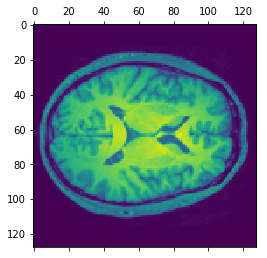

In [46]:
plt.matshow(target[:, :, target.shape[2]//2])